# 대규모 데이터 학습

메모리에 올릴 수 없을만큼 큰 용량의 데이터를 다루는 경우 특정 모델을 사용할 수 없는 문제가 발생한다.

이 경우 사용할 수 있는 모델은 다음과 같다.

- 사전 확률분포를 설정할 수 있는 생성모형

- 시작 가중치를 설정할 수 있는 모형

In [1]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

covtype = fetch_covtype(shuffle=True, random_state=0)
X_covtype = covtype.data
y_covtype = covtype.target - 1
classes = np.unique(y_covtype)
X_train, X_test, y_train, y_test = train_test_split(X_covtype, y_covtype)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def read_Xy(start, end):
    # 실무에서는 파일이나 데이터베이스에서 읽어온다.
    idx = list(range(start, min(len(y_train) - 1, end)))
    X = X_train[idx, :]
    y = y_train[idx]
    return X, y

In [2]:
X_train.shape

(435759, 54)

# SGD

퍼셉트론 모델의 경우 일부 데이터를 이용해 계속해서 가중치를 업데이트하는 방식으로 동작한다.

따라서 전체 데이터를 한번에 학습시킬 필요가 없기에 대용량 데이터 학습이 가능해진다.

현재는 데이터 전체가 메모리에 올릴 수 있기에 한번에 학습시킨 결과를 먼저 확인해보면 다음과 같다.

In [47]:
%%time

from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=0).fit(X_train, y_train)

Wall time: 5.53 s


In [48]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69     52822
           1       0.73      0.80      0.77     70821
           2       0.60      0.88      0.71      9059
           3       0.54      0.09      0.16       741
           4       0.43      0.04      0.07      2341
           5       0.50      0.02      0.04      4350
           6       0.67      0.46      0.55      5119

    accuracy                           0.71    145253
   macro avg       0.60      0.42      0.43    145253
weighted avg       0.70      0.71      0.69    145253



이번에는 데이터를 400개의 조각으로 나누어 조금씩 로드해 2 epoch 만큼 가중치를 업데이트 한 모델의 학습 결과이다.

In [43]:
%%time

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# warm_start=True 
# partial_fit 기존의 값을 지우지 않고 한번 업데이트
model = SGDClassifier(warm_start=True, random_state=0)

n_split = 400
n_X = len(y_train) // n_split
n_epoch = 5
accuracy_train_lst = []
accuracy_test_lst = []

for epoch in range(n_epoch):
    for n in range(n_split):
        X, y = read_Xy(n + n_X, (n + 1) + n_X)
        model.partial_fit(X, y, classes=classes)
        accuracy_train_lst.append(accuracy_score(y_train, model.predict(X_train)))
        accuracy_test_lst.append(accuracy_score(y_test, model.predict(X_test)))
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    print("epoch={:d} train acc={:5.3f} test acc={:5.3f}".format(epoch, accuracy_train, accuracy_test))

epoch=0 train acc=0.625 test acc=0.623
epoch=1 train acc=0.566 test acc=0.565
epoch=2 train acc=0.624 test acc=0.624
epoch=3 train acc=0.633 test acc=0.633
epoch=4 train acc=0.598 test acc=0.596
Wall time: 5min 6s


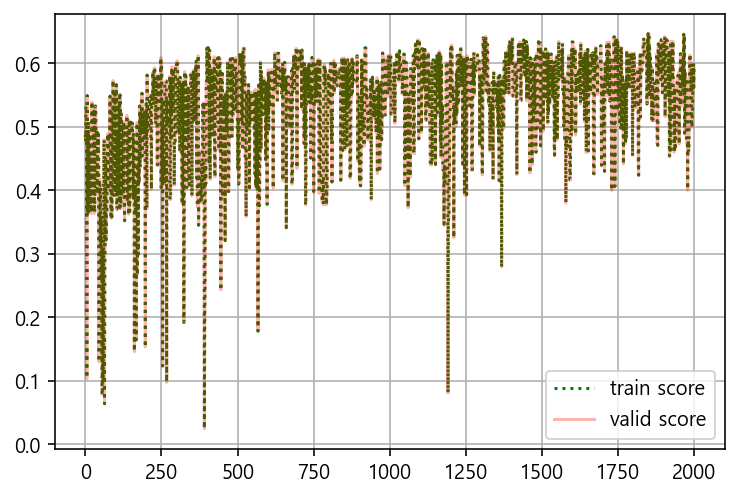

In [44]:
plt.plot(accuracy_train_lst, 'g:', label='train score')
plt.plot(accuracy_test_lst, 'r-', alpha=0.3, label='valid score')
plt.legend()
plt.grid()
plt.show()

# 나이브베이즈

나이브베이즈 모델은 베이즈 정리를 이용해 $p(y|x)$를 구하기 위해 $p(x|y)$ : likelyhood, $p(y)$ :prior를 구한다. 

즉, 나이브베이즈 모델을 이용해 대규모 데이터를 학습하는 경우 일부 데이터를 계속해서 로드하면서 그 일부 데이터의 확률분포를 사전확률분포로 사용하며 점차적으로 정확하게 사전확률분포를 업데이트하는 방식으로 동작한다.

In [58]:
# 전체 데이터 학습

model = BernoulliNB(alpha=0.1).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.47      0.55     52822
           1       0.65      0.77      0.71     70821
           2       0.60      0.85      0.70      9059
           3       0.47      0.70      0.56       741
           4       0.23      0.07      0.10      2341
           5       0.23      0.21      0.22      4350
           6       0.62      0.58      0.60      5119

    accuracy                           0.63    145253
   macro avg       0.49      0.52      0.49    145253
weighted avg       0.63      0.63      0.62    145253



In [59]:
%%time

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = BernoulliNB(alpha=0.1)
accuracy_train_lst = []
accuracy_test_lst = []

n_split = 10
n_X = len(y_train) // n_split
for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model.partial_fit(X, y, classes=classes)
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    accuracy_train_lst.append(accuracy_train)
    accuracy_test_lst.append(accuracy_test)
    print("n={:d} train accuracy={:5.3f} test accuracy={:5.3f}".format(n, accuracy_train, accuracy_test))

n=0 train accuracy=0.629 test accuracy=0.628
n=1 train accuracy=0.628 test accuracy=0.628
n=2 train accuracy=0.633 test accuracy=0.632
n=3 train accuracy=0.633 test accuracy=0.633
n=4 train accuracy=0.633 test accuracy=0.633
n=5 train accuracy=0.633 test accuracy=0.632
n=6 train accuracy=0.632 test accuracy=0.631
n=7 train accuracy=0.632 test accuracy=0.631
n=8 train accuracy=0.632 test accuracy=0.631
n=9 train accuracy=0.632 test accuracy=0.631
Wall time: 4.23 s


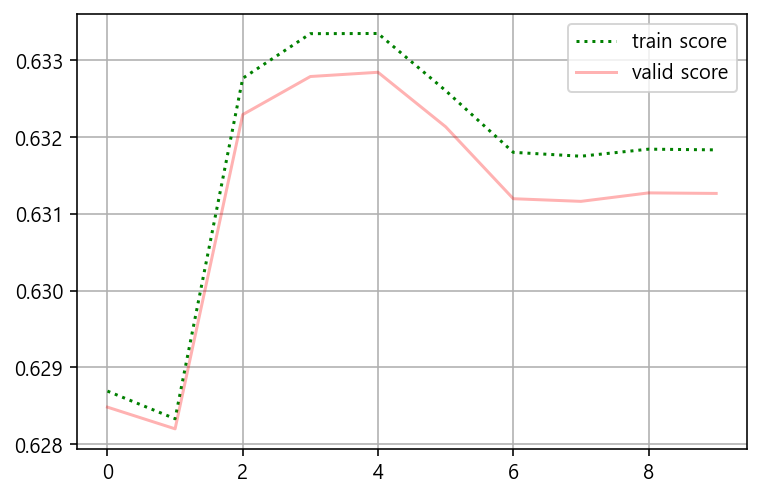

In [60]:
plt.plot(accuracy_train_lst, 'g:', label='train score')
plt.plot(accuracy_test_lst, 'r-', alpha=0.3, label='valid score')
plt.legend()
plt.grid()
plt.show()

업데이트 횟수에 따른 성능을 비교한 결과 최초에는 성능이 나쁘지만 업데이트 횟수가 증가할수록 보다 정확한 likelyhood와 prior를 추정해 성능이 높아지는 것을 확인할 수 있다.

In [61]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.47      0.55     52822
           1       0.65      0.77      0.71     70821
           2       0.60      0.85      0.70      9059
           3       0.47      0.70      0.56       741
           4       0.23      0.07      0.10      2341
           5       0.23      0.21      0.22      4350
           6       0.62      0.58      0.60      5119

    accuracy                           0.63    145253
   macro avg       0.49      0.52      0.49    145253
weighted avg       0.63      0.63      0.62    145253



# RandomForest

Random Forest의 경우 정상적으로는 데이터를 분리해서 학습시킬 수 없지만 일종의 트릭을 이용해 대규모 데이터를 학습시킬 수 있다.

Random Forest란 여러개의 Decision Tree를 이용한다. warm_start 인수를 True로 지정하면 fit할 때마다 n_estimator라는 속성을 조정해 내부적인 Tree를 조정할 수 있다.

예를들어 데이터를 N등분으로 쪼갠 뒤 1번 데이터만를 이용해 M개의 Decision Tree를 만든다.

이후 이후 2번 데이터를 이용해 M개의 Decision Tree를 추가한다.

즉, 원본 데이터의 문제를 푸는게 아니라 데이터를 여러 등분으로 쪼갠 뒤 각각의 데이터를 이용한 문제만을 푸는 Decision Tree를 생성하는 원리로 동작한다.(Bagging과 같은 효과)

추가적으로 RF의 warm_start는 가중치 업데이트 개념이 아닌 기존의 Tree는 건드리지 않고 새로 추가된 Tree에 대해 학습 데이터를 fit하는 기능을 지원하는 인자이다.

In [62]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n_split = 10
accuracy_train_lst = []
accuracy_test_lst = []
n_X = len(y_train) // n_split
num_tree_ini = 10
num_tree_step = 10
model = RandomForestClassifier(n_estimators=num_tree_ini, warm_start=True)
for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model.fit(X, y)
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    print("epoch={:d} train accuracy={:5.3f} test accuracy={:5.3f}".format(n, accuracy_train, accuracy_test))
    accuracy_train_lst.append(accuracy_train)
    accuracy_test_lst.append(accuracy_test)
    model.n_estimators += num_tree_step

epoch=0 train accuracy=0.869 test accuracy=0.854
epoch=1 train accuracy=0.890 test accuracy=0.872
epoch=2 train accuracy=0.899 test accuracy=0.880
epoch=3 train accuracy=0.903 test accuracy=0.885
epoch=4 train accuracy=0.904 test accuracy=0.885
epoch=5 train accuracy=0.905 test accuracy=0.886
epoch=6 train accuracy=0.906 test accuracy=0.887
epoch=7 train accuracy=0.907 test accuracy=0.888
epoch=8 train accuracy=0.908 test accuracy=0.888
epoch=9 train accuracy=0.908 test accuracy=0.889
Wall time: 1min 19s


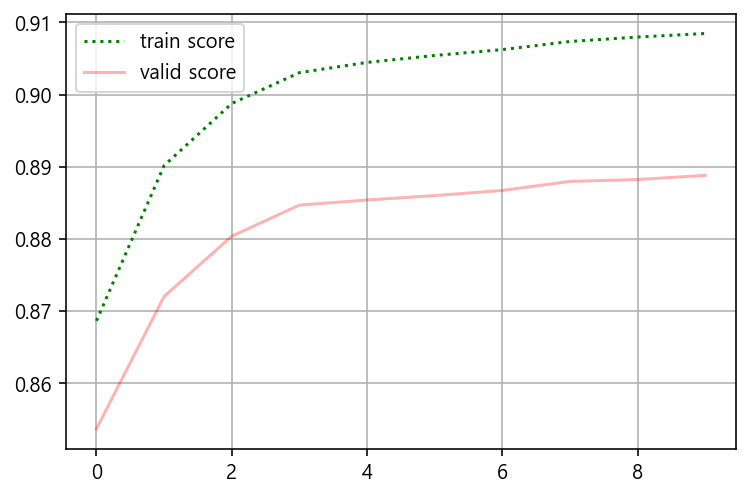

In [63]:
plt.plot(accuracy_train_lst, 'g:', label='train score')
plt.plot(accuracy_test_lst, 'r-', alpha=0.3, label='valid score')
plt.legend()
plt.grid()
plt.show()

In [64]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     52822
           1       0.88      0.94      0.91     70821
           2       0.85      0.91      0.88      9059
           3       0.90      0.69      0.78       741
           4       0.93      0.40      0.56      2341
           5       0.87      0.69      0.77      4350
           6       0.95      0.84      0.89      5119

    accuracy                           0.89    145253
   macro avg       0.90      0.76      0.81    145253
weighted avg       0.89      0.89      0.89    145253

